Modelo baseado no exemplo segmentação de imagem: https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/images/segmentation.ipynb#scrollTo=FD60EbcAQqov

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf
#from tensorflow_examples.models.pix2pix import pix2pix

import os
import numpy as np
from osgeo import gdal

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.layers import Input
from keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda

In [3]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_BANDS = 4
UPCONV = True
CLASS_WEIGHTS = [0.2, 0.3, 0.1, 0.1, 0.3]
images_path = 'Data/BuildingsDataSet/Images/'
masks_path = 'Data/BuildingsDataSet/Masks/'

In [4]:
def load_image(image):
    return gdal.Open(image, gdal.GA_ReadOnly)
    
def convert_to_array(dataset):
    bands = [dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)]
    return np.stack(bands, 2)

def normalize(img):
    min = img.min()
    max = img.max()
    x = 2.0 * (img - min) / (max - min) - 1.0
    return x

In [5]:
files = next(os.walk(images_path))[2]

all_images = []
all_masks = []
num_skipped = 0
for image_file in files:

    image_path = images_path + image_file
    image = load_image(image_path)
    image_data = convert_to_array(image)
    image_data[np.isnan(image_data)] = 1 # adiciona 0 onde é NaN
    image_data = normalize(image_data)

    mask_path = masks_path + image_file
    mask = load_image(mask_path)
    mask_data = convert_to_array(mask)
    mask_data[np.isnan(mask_data)] = 0 # adiciona 0 onde é NaN
    mask_data[mask_data>0] = 1
    mask_data[mask_data<=0] = 0
    
    # Pule qualquer imagem que esteja mais de 99% vazia.
    if np.any(mask_data):
        num_white_pixels = len(mask_data[mask_data==1])
        num_black_pixels = len(mask_data[mask_data==0])
        if num_black_pixels == 0: num_black_pixels = 1 # para evitar erro de dividir por 0

        if num_white_pixels/num_black_pixels < 0.01:
            num_skipped+=1
            continue
        
        all_images.append(image_data)
        all_masks.append(mask_data)
    
    if len(all_images) > 30:
        break

images = np.array(all_images)
masks = np.array(all_masks, dtype=int)
print('Total imagens: \n', len(all_images))
print('Images: \n', images.shape)
print('Masks: \n', masks.shape)
print("\n{} Images were skipped.".format(num_skipped))
print("\nUnique elements in the train mask:", np.unique(masks))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Total imagens: 
 31
Images: 
 (31, 256, 256, 4)
Masks: 
 (31, 256, 256, 1)

39 Images were skipped.

Unique elements in the train mask: [0 1]


In [6]:
TRAIN_LENGTH = 500 #info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
seed = 56

In [7]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(24, 256, 256, 4)
(24, 256, 256, 1)
TEST SET
(7, 256, 256, 4)
(7, 256, 256, 1)


In [29]:
@tf.function
def load_image_train(images, masks):
    image = tf.image.resize(images, (256, 256))
    mask = tf.image.resize(masks, (256, 256))
    
    return tf.data.Dataset.from_tensor_slices((image, mask))

In [30]:
train = load_image_train(train_images, train_masks)
test = load_image_train(test_images, test_masks)

In [31]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [43]:
print(train_dataset)

<PrefetchDataset shapes: ((None, 256, 256, 4), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>


In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        #print(display_list[i][:,:,[1,2,1]])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
#sample_image, sample_mask = train_images[2], train_masks[2]
#display([sample_image, sample_mask])

In [ ]:
"""
for image, mask in train.take(33):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])
"""

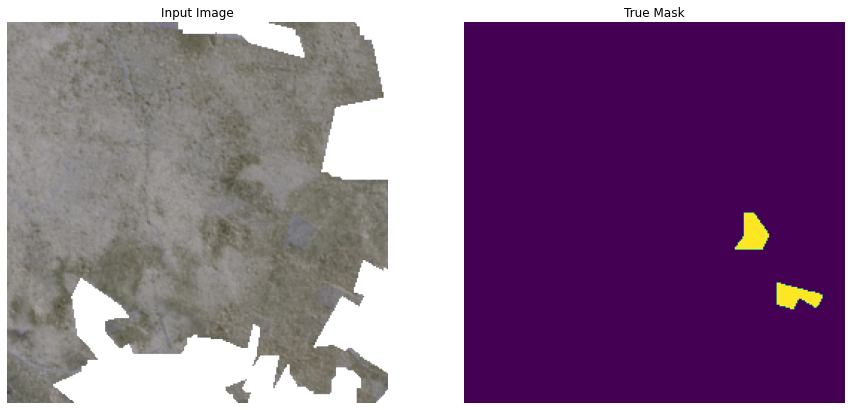

In [9]:
sample_image, sample_mask = train_images[1], train_masks[1]
display([sample_image, sample_mask])

In [10]:
OUTPUT_CHANNELS = 2
N_CLASSES = 1

In [264]:
"""
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use as ativações dessas camadas
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Crie o modelo de extração de características
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
"""

In [257]:
"""
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
"""

In [258]:
"""
def unet_model(output_channels):
    # Esta é a última camada do modelo
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling através do modelo
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling e estabelecimento das conexões de salto
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
"""

In [26]:
"""
model = Sequential([
  #data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(OUTPUT_CHANNELS)
])
"""

In [ ]:
"""
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
"""

In [259]:
#model = unet_model(OUTPUT_CHANNELS)
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [55]:
"""
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
import tensorflow.keras.backend as K

In [ ]:
"""inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
#s = Lambda(lambda x: x) (inputs)
s = Lambda(lambda x: x / 255) (inputs)

kernel_size = (3, 3)
activation = 'elu'

conv1 = Conv2D(16, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)

upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, kernel_size, activation=activation, kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

In [58]:
"""def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [59]:
"""model.compile(optimizer='adam',
              loss=soft_dice_loss,
              metrics=['accuracy'])

In [54]:
"""from ipynb.fs.full.unet_model import *

def get_model():
    return unet_model(N_CLASSES, IMAGE_HEIGHT, n_channels=NUM_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)

model = get_model()

In [ ]:
from ipynb.fs.full.unet_lstm_model import *

model = unet(input_size = (IMAGE_WIDTH, IMAGE_HEIGHT, NUM_BANDS))

model.summary()

In [12]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [13]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in test.take(num):
            pred_mask = model.predict(image[tf.newaxis, ...])
            display([image, mask, create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

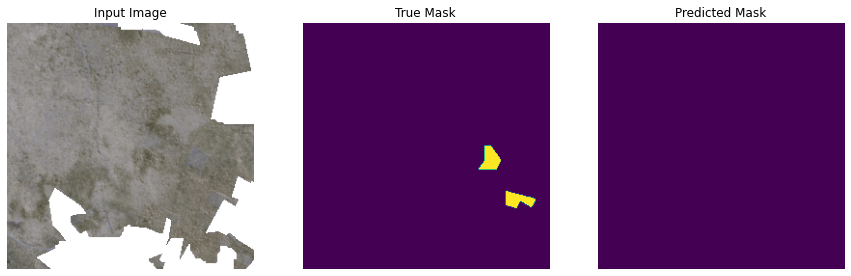

In [14]:
show_predictions()

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [19]:
"""weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path += '/unet_weights.hdf5'

In [21]:
"""from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

if os.path.isfile(weights_path):
    model.load_weights(weights_path)
    
model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('log_unet.csv', append=True, separator=';')

In [16]:
from keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weights', save_best_only=True, monitor='val_loss', mode='min')

In [17]:
EPOCHS = 50
BATCH_SIZE = 16
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 100 #info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(
                  train_images, 
                  train_masks/1, 
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  verbose=1, 
                  shuffle=True,
                  callbacks=[mcp_save]
                )

Epoch 1/50
2/2 [==============================] - 11s 6s/step - loss: 1.1689 - accuracy: 0.3902
Epoch 2/50
2/2 [==============================] - 12s 6s/step - loss: 0.6957 - accuracy: 0.9469
Epoch 3/50
2/2 [==============================] - 12s 6s/step - loss: 0.6939 - accuracy: 0.9529
Epoch 4/50
2/2 [==============================] - 12s 6s/step - loss: 0.6930 - accuracy: 0.9584
Epoch 5/50
2/2 [==============================] - 12s 6s/step - loss: 0.6928 - accuracy: 0.9602
Epoch 6/50
2/2 [==============================] - 11s 6s/step - loss: 0.6927 - accuracy: 0.9603
Epoch 7/50
2/2 [==============================] - 12s 6s/step - loss: 0.6926 - accuracy: 0.9603
Epoch 8/50
2/2 [==============================] - 12s 6s/step - loss: 0.6925 - accuracy: 0.9604
Epoch 9/50
2/2 [==============================] - 12s 6s/step - loss: 0.6924 - accuracy: 0.9604
Epoch 10/50
2/2 [==============================] - 11s 6s/step - loss: 0.6923 - accuracy: 0.9604
Epoch 11/50
2/2 [======================

2/2 [==============================] - 13s 6s/step - loss: 0.6902 - accuracy: 0.9604
Epoch 34/50
2/2 [==============================] - 12s 6s/step - loss: 0.6901 - accuracy: 0.9604
Epoch 35/50
2/2 [==============================] - 12s 6s/step - loss: 0.6901 - accuracy: 0.9604
Epoch 36/50
2/2 [==============================] - 12s 6s/step - loss: 0.6900 - accuracy: 0.9604
Epoch 37/50
2/2 [==============================] - 12s 6s/step - loss: 0.6899 - accuracy: 0.9604
Epoch 38/50
2/2 [==============================] - 12s 6s/step - loss: 0.6898 - accuracy: 0.9604
Epoch 39/50
2/2 [==============================] - 12s 6s/step - loss: 0.6897 - accuracy: 0.9604
Epoch 40/50
2/2 [==============================] - 12s 6s/step - loss: 0.6896 - accuracy: 0.9604
Epoch 41/50
2/2 [==============================] - 13s 7s/step - loss: 0.6895 - accuracy: 0.9604
Epoch 42/50
2/2 [==============================] - 12s 6s/step - loss: 0.6894 - accuracy: 0.9604
Epoch 43/50
2/2 [=========================

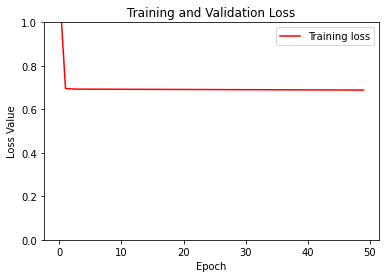

In [20]:
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
#plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_dataset, 5)

In [21]:
predictions = model.predict(test_images, verbose=1)

1/1 [==============================] - 0s 1ms/step


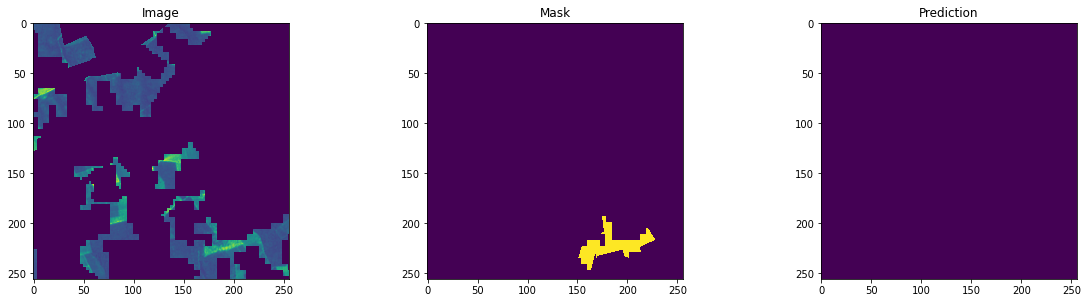

In [31]:
i = 6
p = predictions[i]
#p = p*255
#p[p>0.9] = 1
#p[p<=0.9] = 0

f = plt.figure(figsize=(20,16))

f.add_subplot(3, 3, 1)
# 2 = B4, 1 = B3, 0 = B2
#imshow(test_images[i][:,:,[2,1,0]])
plt.imshow(test_images[i][:,:,2]/10000)
plt.title('Image')

f.add_subplot(3, 3, 2)
plt.imshow(test_masks[i])
plt.title('Mask')

f.add_subplot(3, 3, 3)
plt.imshow(p)
plt.title('Prediction')

# colorido
#f.subplot(3, 3, 3)
#plt.imshow(p)
#plt.title('Prediction')
        
plt.show()